In [ ]:
# Add scripts to path and fix working directory
import sys
import os
from pathlib import Path

# Change to project root (two levels up from notebook)
notebook_dir = Path.cwd()
project_root = (
    Path(__file__).parent.parent.parent
    if "__file__" in locals()
    else Path("/home/Plutonium/Documents/BioinfoMidterm")
)

os.chdir(project_root)
sys.path.insert(0, str(project_root / "scripts"))

print(f"Working directory: {os.getcwd()}")

# Import config module and set population FIRST
import config as cfg
cfg.set_population_config("sea_jpt_cn")

# Now create aliases (pointing to updated config)
PATHS = cfg.PATHS
HARD_FILTERS = cfg.HARD_FILTERS
POPULATIONS = cfg.POPULATIONS

# Import other modules
from utils import read_panel, extract_population_samples, analyze_afreq
from hard_filters import (
    filter_snp_biallelic,
    filter_maf,
    calculate_frequencies,
    apply_all_hard_filters,
)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Print configuration
cfg.print_config_summary()

Working directory: /home/Plutonium/Documents/BioinfoMidterm
CONFIGURATION SUMMARY

--- PATHS ---
  Config name:    sea_jpt_cn
  Output dir:     1000genomes/output_sea_jpt_cn
  VCF dir:        1000genomes/vcf_sea_jpt_cn
  Samples CSV:    1000genomes/SEA_JPT_CN_subpopulation_samples.csv

--- HARD FILTERS (Always Applied) ---
  SNP-only:      True
  Max alleles:   2
  Min AF:        0.0016
  Min call rate: 0.95

--- SITUATIONAL FILTERS (Context-Dependent) ---
  HWE threshold: 1e-06
  HWE mode:      keep-fewhet
  LD window:     1000kb
  LD step:       1
  LD R² cutoff:  0.1
  FST top N:     1000

--- POPULATIONS ---
  Config name:    sea_jpt_cn
  Raw subpops:    ('CHB', 'JPT', 'CHS', 'CDX', 'KHV')
  Target pops:    ('CN', 'JPT', 'SEA')
  Merge mapping:  {'CHB': 'CN', 'CHS': 'CN', 'JPT': 'JPT', 'KHV': 'SEA', 'CDX': 'SEA'}
  Num samples:    504
PathConfig(config_name='sea_jpt_cn', ROOT=PosixPath('/home/Plutonium/Documents/BioinfoMidterm'), VCF_FILE=PosixPath('1000genomes/main_vcf/ALL_merged.

## Step 1: Prepare Sample List

Extract EAS subpopulation samples (CHB, JPT, CHS, CDX, KHV) from the panel file.
These will be merged into 3 groups: CN (CHB+CHS), JPT, SEA (KHV+CDX).

In [13]:
# Read panel file
panel_df = read_panel(PATHS.PANEL_FILE)
panel_df = panel_df[["sample", "pop", "super_pop"]]
print("Panel DataFrame:")
display(panel_df.head())
print(f"\nTotal samples: {len(panel_df)}")
print(f"\nPopulation counts:")
display(panel_df['pop'].value_counts())

Panel DataFrame:


,sample,pop,super_pop
0,HG00096,GBR,EUR
1,HG00097,GBR,EUR
2,HG00099,GBR,EUR
3,HG00100,GBR,EUR
4,HG00101,GBR,EUR



Total samples: 2504

Population counts:


pop
GWD    113
YRI    108
IBS    107
TSI    107
CHS    105
PUR    104
JPT    104
CHB    103
GIH    103
ITU    102
STU    102
ESN     99
CEU     99
LWK     99
FIN     99
KHV     99
PJL     96
ACB     96
CLM     94
CDX     93
GBR     91
BEB     86
PEL     85
MSL     85
MXL     64
ASW     61
Name: count, dtype: int64

In [14]:
# Extract EAS subpopulations using RAW_SUBPOPS (before merging)
# For sea_jpt_cn: CHB, JPT, CHS, CDX, KHV
RAW_SUBPOPS = list(POPULATIONS.RAW_SUBPOPS)
print(f"Extracting raw populations: {RAW_SUBPOPS}")

# Filter panel to raw subpopulations
eas_df = panel_df[panel_df["pop"].isin(RAW_SUBPOPS)].copy()
print(f"\nRaw population counts:")
display(eas_df['pop'].value_counts())

# Apply merge mapping to create target populations (CN, JPT, SEA)
if POPULATIONS.POP_MERGE_MAP:
    print(f"\nApplying merge mapping: {POPULATIONS.POP_MERGE_MAP}")
    eas_df["pop"] = eas_df["pop"].map(POPULATIONS.POP_MERGE_MAP)
    print(f"\nMerged population counts:")
    display(eas_df['pop'].value_counts())

# Save full metadata (no header for PLINK compatibility)
samples_csv = PATHS.get_absolute(PATHS.EAS_SAMPLES_CSV)
samples_list = PATHS.get_absolute(PATHS.EAS_SAMPLES_LIST)
samples_csv.parent.mkdir(parents=True, exist_ok=True)

eas_df[["sample", "pop", "super_pop"]].to_csv(samples_csv, index=False, header=False)
eas_df[["sample"]].to_csv(samples_list, index=False, header=False)

eas_samples = eas_df["sample"].tolist()
print(f"\nSaved {len(eas_samples)} samples to:")
print(f"  CSV: {samples_csv}")
print(f"  List: {samples_list}")

Extracting raw populations: ['CHB', 'JPT', 'CHS', 'CDX', 'KHV']

Raw population counts:


pop
CHS    105
JPT    104
CHB    103
KHV     99
CDX     93
Name: count, dtype: int64


Applying merge mapping: {'CHB': 'CN', 'CHS': 'CN', 'JPT': 'JPT', 'KHV': 'SEA', 'CDX': 'SEA'}

Merged population counts:


pop
CN     208
SEA    192
JPT    104
Name: count, dtype: int64


Saved 504 samples to:
  CSV: /home/Plutonium/Documents/BioinfoMidterm/1000genomes/SEA_JPT_CN_subpopulation_samples.csv
  List: /home/Plutonium/Documents/BioinfoMidterm/1000genomes/SEA_JPT_CN_subpopulation_samples_list.csv


## Step 1b: Prepare for PLINK2 Filtering

Note: We use PLINK2 directly for SNP-only and biallelic filtering instead of bcftools.
PLINK2 handles this efficiently with `--snps-only` and `--max-alleles 2` flags.

In [15]:
import subprocess
from pathlib import Path

# Skip bcftools - use PLINK2 directly for SNP-only biallelic filtering
# The filter_snp_biallelic function in Step 2 will handle SNP-only + biallelic filtering
# using PLINK2's --snps-only and --max-alleles 2 flags

print("Note: Skipping bcftools step - using PLINK2 directly for filtering")
print("PLINK2 will apply SNP-only and biallelic filters in the next step")
print(f"\nInput VCF for PLINK: {PATHS.VCF_FILE}")

Note: Skipping bcftools step - using PLINK2 directly for filtering
PLINK2 will apply SNP-only and biallelic filters in the next step

Input VCF for PLINK: 1000genomes/main_vcf/ALL_merged.vcf.gz


## Step 2: Apply SNP-only and Biallelic Filter

**HARD FILTER 1**: Keep only single nucleotide polymorphisms with at most 2 alleles.

In [16]:
# Apply SNP-only + biallelic filter using PLINK2 directly from source VCF
step1_output = filter_snp_biallelic(
    input_vcf=str(PATHS.VCF_FILE),  # Use the source VCF directly
    output_pfile=str(PATHS.PLINK_SNP_FILTERED),
    keep_samples=str(PATHS.EAS_SAMPLES_LIST),
    verbose=True,
)

HARD FILTER 1: SNP-only and Biallelic
  SNP-only: True
  Max alleles: 2
  Sample filter: 1000genomes/SEA_JPT_CN_subpopulation_samples_list.csv
Running: plink2 --threads 8 --vcf 1000genomes/main_vcf/ALL_merged.vcf.gz --snps-only --max-alleles 2 --keep 1000genomes/SEA_JPT_CN_subpopulation_samples_list.csv --make-pgen --out 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data
PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data.log.
Options in effect:
  --keep 1000genomes/SEA_JPT_CN_subpopulation_samples_list.csv
  --make-pgen
  --max-alleles 2
  --out 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data
  --snps-only
  --threads 8
  --vcf 1000genomes/main_vcf/ALL_merged.vcf.gz

Start time: Sun Feb  1 08:44:07 2026
15686 MiB RAM detected, ~9488 available; reserving 7843 MiB for main workspace.

--vcf: 81271745 variants scanned.
--vcf: 81263k variants converted.
1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data-temporary.pgen +
1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data-temporary.pvar.zst
+ 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data-temporary.psam
written.
2504 samples (0 females, 0 males, 2504 ambiguous; 2504 founders) loaded from
1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data-temporary.psam.
77818345 out of 81271745 variants loaded from
1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data-temporary.pvar.zst.
Note: No phenotype data present.
--keep: 504 samples remaining.
504 samples (0 females, 0 males, 504 ambiguous; 504 founders) remaining after
main filters.
77818345 variants remaining after main filters.
Writing 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data.psam ...
done.
Writing 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data.pvar ...
10101111121213131414151516

## Step 2b: Export SNP-Filtered Data to VCF

Export the SNP-only biallelic filtered PLINK data back to VCF format using PLINK2.

In [17]:
# Export SNP-filtered PLINK data to VCF using PLINK2
import subprocess
from pathlib import Path

# Save to main_vcf directory to be used by notebooks 07 and 08
main_vcf_dir = Path(step1_output).parent.parent / "main_vcf"
main_vcf_dir.mkdir(parents=True, exist_ok=True)

output_vcf_path = str(main_vcf_dir / "SEA_JPT_CN_main_vcf.vcf.gz")
output_prefix = output_vcf_path.replace(".vcf.gz", "")

cmd_export = [
    "plink2",
    "--pfile", step1_output,
    "--export", "vcf", "bgz",
    "--out", output_prefix
]

print(f"Exporting to VCF: {output_vcf_path}")
print(f"Command: {' '.join(cmd_export)}")

result = subprocess.run(cmd_export, capture_output=True, text=True)

if result.returncode != 0:
    print(f"Error: {result.stderr}")
else:
    print(f"✓ VCF exported successfully")
    
# Verify the output exists


Exporting to VCF: 1000genomes/main_vcf/SEA_JPT_CN_main_vcf.vcf.gz
Command: plink2 --pfile 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data --export vcf bgz --out 1000genomes/main_vcf/SEA_JPT_CN_main_vcf
✓ VCF exported successfully


In [18]:
vcf_output = f"{output_prefix}.vcf.gz"
if Path(vcf_output).exists():
    print(f"✓ Output VCF file: {vcf_output}")
    
    # Create tabix index for the VCF (using 8 threads)
    cmd_index = ["tabix", "-@", "8", "-p", "vcf", vcf_output]
    print(f"\nIndexing VCF: {' '.join(cmd_index)}")
    
    result_idx = subprocess.run(cmd_index, capture_output=True, text=True)
    
    if result_idx.returncode != 0:
        print(f"Error indexing: {result_idx.stderr}")
    else:
        print(f"✓ VCF index created: {vcf_output}.tbi")
        print(f"\nVCF ready for notebooks 07 and 08")

✓ Output VCF file: 1000genomes/main_vcf/SEA_JPT_CN_main_vcf.vcf.gz

Indexing VCF: tabix -@ 8 -p vcf 1000genomes/main_vcf/SEA_JPT_CN_main_vcf.vcf.gz
✓ VCF index created: 1000genomes/main_vcf/SEA_JPT_CN_main_vcf.vcf.gz.tbi

VCF ready for notebooks 07 and 08


In [19]:
# Calculate frequency statistics after Step 1
freq_prefix = calculate_frequencies(
    step1_output,
    output_prefix=f"{step1_output}_info",
)

Calculating frequency statistics: 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data_info.afreq
Running: plink2 --threads 8 --pfile 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data --freq --out 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data_info
PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data_info.log.
Options in effect:
  --freq
  --out 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data_info
  --pfile 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data
  --threads 8

Start time: Sun Feb  1 09:15:39 2026
15686 MiB RAM detected, ~8368 available; reserving 7843 MiB for main workspace.
Using up to 8 compute threads.
504 samples (0 females, 0 males, 504 ambiguous; 504 founders) loaded from
1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtere

In [20]:
# Analyze frequency statistics
afreq_file = f"{freq_prefix}.afreq"
df_freq, qc_summary = analyze_afreq(
    afreq_file,
    num_samples=POPULATIONS.NUM_SAMPLES,
    maf_threshold=0.01,
    cr_threshold=0.95,
)

Loading data: 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data_info.afreq
Loaded 77818345 variants.
   ALT_FREQS  OBS_CT       MAF  CALL_RATE
0   0.000000    1008  0.000000        1.0
1   0.000000    1008  0.000000        1.0
2   0.000000    1008  0.000000        1.0
3   0.000000    1008  0.000000        1.0
4   0.000992    1008  0.000992        1.0

--- QC Summary ---
Variants failing MAF < 0.01: 70267772 (90.30%)
Variants failing Call Rate < 0.95: 0 (0.00%)


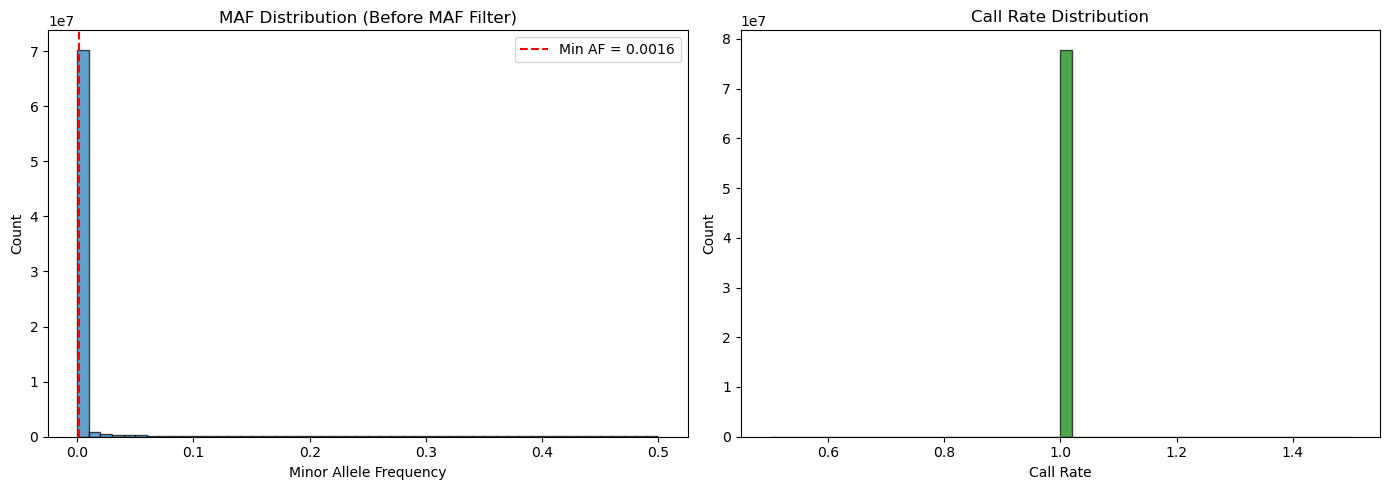


Note: Call rate is 100% for 1000 Genomes data (no missing genotypes)


In [21]:
# Visualize MAF distribution BEFORE MAF filter
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MAF histogram
axes[0].hist(df_freq['MAF'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(HARD_FILTERS.MIN_AF, color='red', linestyle='--', label=f'Min AF = {HARD_FILTERS.MIN_AF}')
axes[0].set_xlabel('Minor Allele Frequency')
axes[0].set_ylabel('Count')
axes[0].set_title('MAF Distribution (Before MAF Filter)')
axes[0].legend()

# Call rate histogram
axes[1].hist(df_freq['CALL_RATE'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Call Rate')
axes[1].set_ylabel('Count')
axes[1].set_title('Call Rate Distribution')

plt.tight_layout()
plt.show()

print(f"\nNote: Call rate is 100% for 1000 Genomes data (no missing genotypes)")

## Step 3: Apply MAF Filter

**HARD FILTER 2**: Remove variants with very low allele frequency.

Threshold: 1/612 = 0.0016 (at least 1 allele in 306 diploid samples)

In [22]:
# Apply MAF filter
step2_output = filter_maf(
    input_pfile=step1_output,
    output_pfile=str(PATHS.PLINK_MAF_FILTERED),
    min_af=HARD_FILTERS.MIN_AF,
    verbose=True,
)

HARD FILTER 2: Minor Allele Frequency (MAF)
  Min AF threshold: 0.0016
  Input variants: 77818345
Running: plink2 --threads 8 --pfile 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data --min-af 0.0016 --make-pgen --out 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data_MAF_filtered
PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data_MAF_filtered.log.
Options in effect:
  --maf 0.0016
  --make-pgen
  --out 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data_MAF_filtered
  --pfile 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data
  --threads 8

Start time: Sun Feb  1 09:17:01 2026
15686 MiB RAM detected, ~6668 available; reserving 6604 MiB for main workspace.
Using up to 8 compute threads.
504 samples (0 females, 0 males, 504 ambiguous; 504 founders) loaded from
1

In [23]:
# Calculate frequency statistics after MAF filter
freq_prefix_maf = calculate_frequencies(
    step2_output,
    output_prefix=f"{step2_output}_info",
)

Calculating frequency statistics: 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data_MAF_filtered_info.afreq
Running: plink2 --threads 8 --pfile 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data_MAF_filtered --freq --out 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data_MAF_filtered_info
PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data_MAF_filtered_info.log.
Options in effect:
  --freq
  --out 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data_MAF_filtered_info
  --pfile 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data_MAF_filtered
  --threads 8

Start time: Sun Feb  1 09:17:44 2026
15686 MiB RAM detected, ~6648 available; reserving 6584 MiB for main workspace.
Using up to 8 compute threads.
504 samples (0 females, 0 males, 504 ambiguous; 504 

In [24]:
# Analyze frequency statistics after MAF filter
afreq_file_maf = f"{freq_prefix_maf}.afreq"
df_freq_maf, qc_summary_maf = analyze_afreq(
    afreq_file_maf,
    num_samples=POPULATIONS.NUM_SAMPLES,
    maf_threshold=0.01,
    cr_threshold=0.95,
)

Loading data: 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data_MAF_filtered_info.afreq
Loaded 12405513 variants.
   ALT_FREQS  OBS_CT       MAF  CALL_RATE
0   0.002976    1008  0.002976        1.0
1   0.036706    1008  0.036706        1.0
2   0.036706    1008  0.036706        1.0
3   0.001984    1008  0.001984        1.0
4   0.024802    1008  0.024802        1.0

--- QC Summary ---
Variants failing MAF < 0.01: 4854940 (39.14%)
Variants failing Call Rate < 0.95: 0 (0.00%)


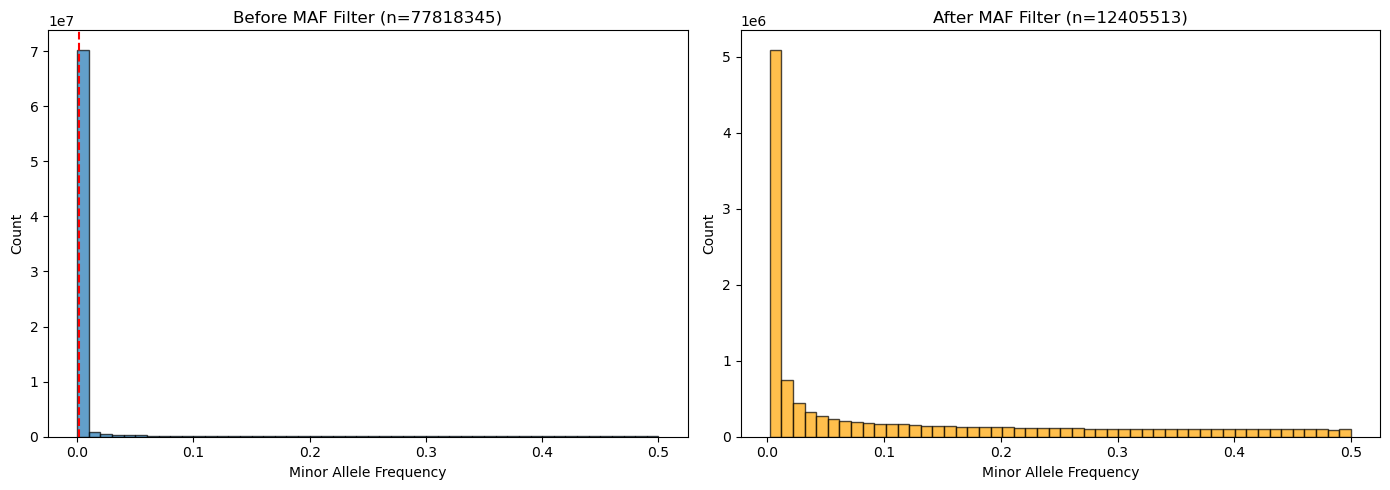

In [25]:
# Compare before and after MAF filter
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before MAF filter
axes[0].hist(df_freq['MAF'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(HARD_FILTERS.MIN_AF, color='red', linestyle='--')
axes[0].set_xlabel('Minor Allele Frequency')
axes[0].set_ylabel('Count')
axes[0].set_title(f'Before MAF Filter (n={len(df_freq)})')

# After MAF filter
axes[1].hist(df_freq_maf['MAF'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Minor Allele Frequency')
axes[1].set_ylabel('Count')
axes[1].set_title(f'After MAF Filter (n={len(df_freq_maf)})')

plt.tight_layout()
plt.show()

## Summary

Hard filtering complete. The output can now be passed to situational filters.

In [26]:
print("="*60)
print("HARD FILTERING SUMMARY")
print("="*60)
print(f"\nFilters applied:")
print(f"  1. SNP-only: Yes")
print(f"  2. Biallelic (max 2 alleles): Yes")
print(f"  3. Sample subsetting: {RAW_SUBPOPS} -> {list(POPULATIONS.TARGET_POPS)}")
print(f"  4. MAF >= {HARD_FILTERS.MIN_AF}")
print(f"\nVariant counts:")
print(f"  After SNP/biallelic: {len(df_freq)}")
print(f"  After MAF filter: {len(df_freq_maf)}")
print(f"  Removed by MAF: {len(df_freq) - len(df_freq_maf)} ({(len(df_freq) - len(df_freq_maf))/len(df_freq)*100:.2f}%)")
print(f"\nOutput file: {step2_output}")
print(f"\nNext step: Run 02_situational_filtering.ipynb")

HARD FILTERING SUMMARY

Filters applied:
  1. SNP-only: Yes
  2. Biallelic (max 2 alleles): Yes
  3. Sample subsetting: ['CHB', 'JPT', 'CHS', 'CDX', 'KHV'] -> ['CN', 'JPT', 'SEA']
  4. MAF >= 0.0016

Variant counts:
  After SNP/biallelic: 77818345
  After MAF filter: 12405513
  Removed by MAF: 65412832 (84.06%)

Output file: 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data_MAF_filtered

Next step: Run 02_situational_filtering.ipynb
